# Synthetic data

In [2]:
import timeit
import warnings

import numpy as np
import shap
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from utils import heat_map
import ruptures as rpt

from window_shap import SlidingWindowSHAP, StationaryWindowSHAP, DynamicWindowSHAP

warnings.filterwarnings('ignore')

%matplotlib inline
shap.initjs()

This function generates a synthetic time series in which each feature sequence is generated using the sin() or cos() function. However, an anomaly interval is inserted at random into one of the feature sequences. If the feature with the anomaly is the first feature, the sample label is 1; otherwise, it is 0.

In [142]:
def synthetic_data(n_samples=100, n_steps=10, n_features=4):
    # Creating input data
    lam = 0.2
    anomaly_lam = 10
    eps = np.random.normal
    x = np.zeros((n_samples, n_steps, n_features))
    labels = np.zeros(n_samples)
    for i in range(n_samples):
        t0 = np.random.randint(1, 5, size=n_features)
        w = np.random.randint(1, 5, size=n_features)
        t = np.arange(n_steps)
        for j in range(n_features):
            if j % 2 == 0:
                x[i, :, j] = np.sin((t - t0[j]) / w[j])
            else:
                x[i, :, j] = np.cos((t - t0[j]) / w[j])
            x[i, :, j] = x[i, :, j] + lam * eps(size=n_steps)

        # adding anomaly
        #         anom_dur = np.random.randint(n_steps/10, n_steps/2)
        anom_dur = 20
        anom_start = np.random.randint(0, n_steps - anom_dur)
        anom_end = anom_start + anom_dur

        anom_j = np.random.randint(0, n_features)
        x[i, anom_start:anom_end, anom_j] += anomaly_lam * eps(size=anom_dur)

        # Creating the label
        labels[i] = 1 if anom_j == 0 else 0
    return x, labels

Data seperation to test and train

In [215]:
x, label = synthetic_data(n_samples=100, n_steps=120, n_features=4)

In [216]:
print(label)

[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [217]:
train_x, test_x, train_y, test_y = train_test_split(x, label, test_size=0.3, random_state=0,
                                                    stratify=label)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0,
                                                  stratify=train_y)

# Prediction Model

In [218]:
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

num_hidden = [70, 20]
num_neurons = 200
es_patience = 20
epochs = 1
num_output = 1
batch_size = 32
drop_rate = 0.3
reg_rate = 0.004

K.clear_session()
model = Sequential()
input_shape = (x.shape[1], x.shape[2])
model.add(GRU(units=num_neurons, activation='relu', input_shape=input_shape,
              recurrent_dropout=0.1, dropout=0.1))
for i in num_hidden:
    model.add(Dropout(drop_rate))
    model.add(Dense(units=i, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)))
model.add(Dense(units=num_output, activation='sigmoid'))

# Creating and compiling model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=es_patience)

# Class weights
class_weights = {0: len(train_y) / (train_y == 0).sum(),
                 1: len(train_y) / (train_y == 1).sum()}

model.compile(optimizer=SGD(learning_rate=0.01, clipvalue=0.5), loss='binary_crossentropy',
              metrics=['accuracy'])
# model.build(input_shape)
model.summary()
train_history = model.fit(train_x, train_y, batch_size=batch_size,
                          epochs=epochs, verbose=2,
                          validation_data=(val_x, val_y),
                          class_weight=class_weights,
                          callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               123600    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 70)                14070     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                1420      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 139111 (543.40 KB)
Trainable params: 13911

In [219]:
from sklearn.metrics import roc_auc_score, accuracy_score

print(roc_auc_score(test_y, model.predict(test_x)))
print(accuracy_score(test_y, np.round(model.predict(test_x))))

1/1 [==============================] - 0s 420ms/step
0.6666666666666667
1/1 [==============================] - 0s 44ms/step
0.7


In [220]:
test_y[20:30]

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 1.])

## SHAP interpretation

In [221]:
num_background = 50
num_test = 28
background_data, test_data = train_x[:num_background], test_x[num_test:num_test + 2]

## 4- Ruptures Dynamic WindowSHAP

In [262]:
from window_shap import *

class RupturesDynamicWindowSHAP(SHAP):
    """RupturesDynamicWindowSHAP class"""

    def __init__(self, model, delta, n_w, B_ts, test_ts, B_mask=None, B_dem=None,
                 test_mask=None, test_dem=None, model_type='lstm'):

        self.delta = delta
        self.n_w = n_w
        num_window = [1] * B_ts.shape[2]
        super().__init__(model, B_ts, test_ts, num_window, B_mask,
                         B_dem, test_mask, test_dem, model_type)

        # algo = rpt.Pelt(model="rbf").fit(B_ts)
        # result = algo.predict(pen=10)
        #self.split_points = [[self.num_ts_step - 1]] * self.num_ts_ftr  # Splitting points
        self.split_points = [[self.num_ts_step - 1]] * self.num_ts_ftr  # Splitting points
        
        print(self.num_ts_step)
        print(self.num_ts_ftr)
        self.split_points = [[rpt.Pelt(model="rbf").fit(data).predict(pen=3)] for data in B_ts]  # Splitting points
        print("Split points")
        print(self.split_points)

        self.prepare_data(dynamic=True)

    def get_ts_x_(self, x):
        return np.zeros((x.shape[0], self.num_ts_step, self.num_ts_ftr))

    def get_ts_x(self, x):
        ts_x = x[:, self.num_dem_ftr:].copy()

        temp_ts_x = np.zeros((ts_x.shape[0], max(self.num_window), self.num_ts_ftr), dtype=int)
        for i in range(self.num_ts_ftr):
            temp_ts_x[:, :self.num_window[i], i] = ts_x[:, sum(self.num_window[:i]):sum(
                self.num_window[:i + 1])]
        return temp_ts_x

    def get_tstep(self, x):
        return np.ones((x.shape[0], self.num_ts_step, 1)) * \
            np.reshape(np.arange(0, self.num_ts_step), (1, self.num_ts_step, 1))

    def creating_data(self, x, ts_x, ts_x_, mask_x_, start_ind=0):
        for i in range(x.shape[0]):
            # creating time series data
            for j in range(self.num_ts_ftr):
                # Finding the corresponding time interval
                wind_t = np.searchsorted(self.split_points[j], np.arange(
                    self.num_ts_step))  ## Specific to Binary Time Window
                for t in range(self.num_ts_step):
                    ind = ts_x[i, wind_t[t], j]
                    ts_x_[i, t, j] = self.all_ts[ind, t, j]
                    mask_x_[i, t, j] = None if self.all_mask is None else self.all_mask[ind, t, j]
        return ts_x_, mask_x_

    def shap_values(self, num_output=1, nsamples_in_loop='auto', nsamples_final='auto'):
        """shap value for dynamic window."""

        flag = 1
        while flag:
            flag = 0

            # Updating the number of time windows for each time series feature
            self.num_window = [len(self.split_points[i]) for i in range(self.num_ts_ftr)]
            print("Num windows")
            print(self.num_window)

            # Updating converted data for SHAP
            self.background_data = data_prepare(self.B_ts,
                                                self.num_dem_ftr,
                                                self.num_window,
                                                self.num_ts_ftr,
                                                dynamic=True)
            self.test_data = data_prepare(self.test_ts,
                                          self.num_dem_ftr,
                                          self.num_window,
                                          self.num_ts_ftr,
                                          len(self.B_ts),
                                          dynamic=True)

            # Running SHAP
            if nsamples_in_loop == 'auto':
                nsamples = 2 * sum(self.num_window)
            else:
                nsamples = nsamples_in_loop

            self.explainer = shap.KernelExplainer(self.wrapper_predict, self.background_data)
            shap_values = self.explainer.shap_values(self.test_data, nsamples=nsamples)
            shap_values = np.array(shap_values)
            dem_phi = shap_values[0, :, :self.num_dem_ftr]  # Extracting dem SHAP values
            ts_shap_values = shap_values[:, :, self.num_dem_ftr:]  # Extracting ts SHAP values

            # Checking the maximum number of windows condition
            if max(self.num_window) >= self.n_w: break

            for i in range(self.num_ts_ftr):
                S = set(self.split_points[i])
                for j in range(self.num_window[i]):
                    if abs(ts_shap_values[0, 0, sum(self.num_window[:i]) + j]) > self.delta:
                        S.add(int(self.split_points[i][j] / 2) if j == 0 else int(
                            (self.split_points[i][j - 1] + self.split_points[i][j]) / 2))
                if set(S) != set(self.split_points[i]):
                    flag += 1
                    self.split_points[i] = list(S)
                    self.split_points[i].sort()

        # Running SHAP with large number of samples for the final evaluation of Shapely values
        self.explainer = shap.KernelExplainer(self.wrapper_predict, self.background_data)
        shap_values = self.explainer.shap_values(self.test_data, nsamples=nsamples_final)
        shap_values = np.array(shap_values)
        dem_phi = shap_values[0, :, :self.num_dem_ftr]  # Extracting dem SHAP values
        ts_shap_values = shap_values[:, :, self.num_dem_ftr:]  # Extracting ts SHAP values

        # Assigning Shap values to each single time step
        ts_phi = np.zeros((len(self.test_ts), self.num_ts_step, self.num_ts_ftr))
        for i in range(self.num_ts_ftr):
            for j in range(self.num_window[i]):
                # This part of the code is written in a way that each splitting point belongs to the time window that starts from that point
                # For the last time window, both splitting points at the end and start of the time window belong to it
                start_ind = 0 if j == 0 else self.split_points[i][j - 1]
                end_ind = self.split_points[i][j] + int((j + 1) / self.num_window[i])
                ts_phi[0, start_ind:end_ind, i] = ts_shap_values[0, :,
                                                  sum(self.num_window[:i]) + j] / (
                                                          end_ind - start_ind)
        self.dem_phi = dem_phi
        self.ts_phi = ts_phi

        return ts_phi if self.num_dem_ftr == 0 else (dem_phi, ts_phi)

(1000, 4)
[210, 410, 605, 795, 1000]


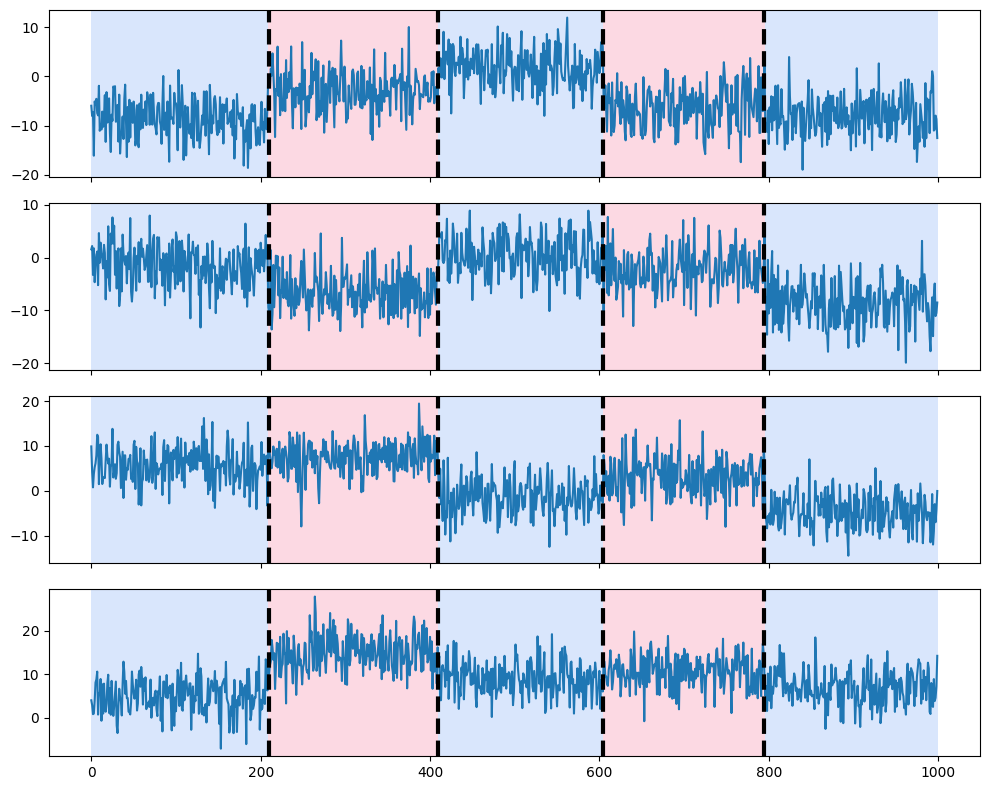

In [223]:
import matplotlib.pyplot as plt
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 4, 4
n_bkps = 4  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=3)

print(signal.shape)
print(result)
# display
rpt.display(signal, bkps, result)
plt.show()

In [224]:
print(signal.shape)

(1000, 4)


In [225]:
print(background_data[1].shape)

(120, 4)


In [226]:
print(background_data[0].shape)
print(background_data.shape[0])
# print(test_data[i:i + 1].shape)
# 

(120, 4)
50


[10, 35, 120]


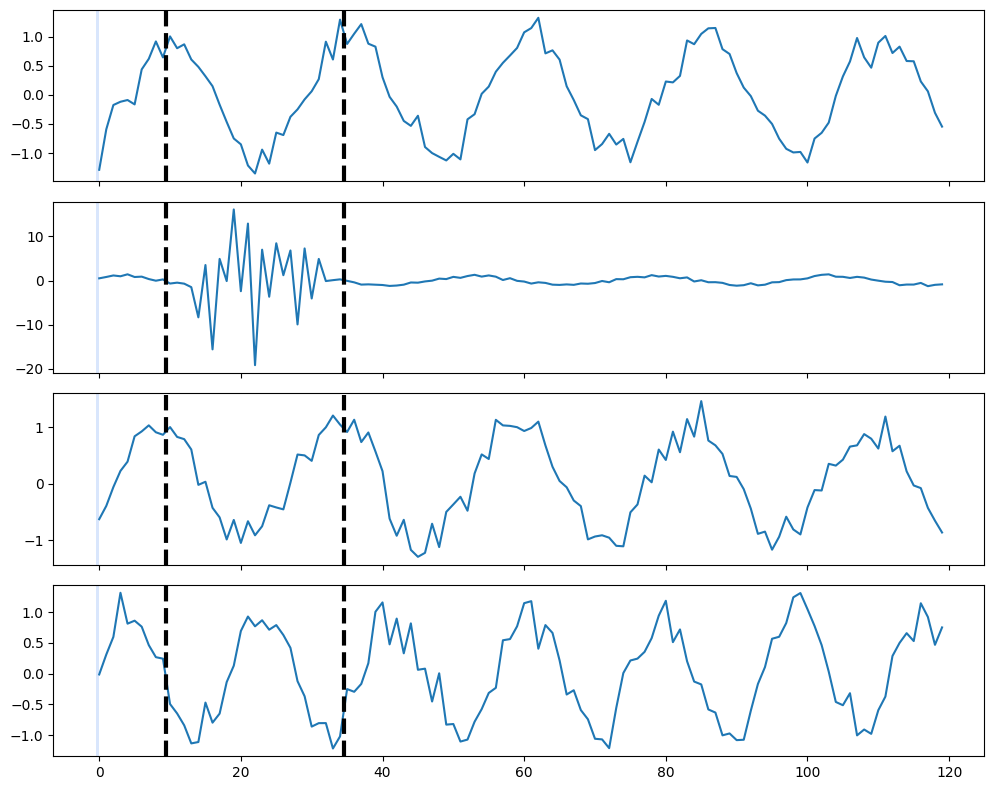

In [227]:
data = background_data[0]
algo = rpt.Pelt(model="rbf").fit(data)
result = algo.predict(pen=3)

print(result)
rpt.display(data, [0], result)
plt.show()

In [228]:
for i in range(background_data.shape[0]):
    data = background_data[i]
    algo = rpt.Pelt(model="rbf").fit(data)
    result = algo.predict(pen=2)
    
    # print(result)
    # rpt.display(data, [0], result)
    # plt.show()
    

In [263]:
tic = timeit.default_timer()
ts_phi_4 = np.zeros((len(test_data), test_data.shape[1], test_data.shape[2]))
for i in range(len(test_data)):
    delta = 0.3
    n_w = 8
    rtw = RupturesDynamicWindowSHAP(model, delta, n_w, background_data, test_data[i:i + 1],
                            model_type='lstm')
    ts_phi_4[i, :, :] = rtw.shap_values()
print('Total time: ' + str(timeit.default_timer() - tic))

120
4
Split points
[[119], [119], [119], [119]]
splits
1
1
1
1
Num windows
[None, None, None, None]


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [257]:
print(ts_phi_4.shape)

(2, 120, 4)


In [259]:
var = 0
phi_index = 0
heat_map(start=0, stop=120, x=test_x[num_test + phi_index, :, var],
         shap_values=ts_phi_4[phi_index, :, var], var_name='Variable', plot_type='bar')

ValueError: You must provide at least 2 boundaries (1 region) but you passed in array([0.])